In [1]:
# Algorithm 1: Four-query Clifford Tester
# https://www.arxiv.org/abs/2510.07164 pg. 21

from qiskit import QuantumCircuit

from lib.clifford_tester import clifford_tester, get_clifford_tester_circuit

In [2]:
# Test with Clifford gates (should accept with high probability)
print("Testing Clifford gates:")

# Hadamard (Clifford)
H = QuantumCircuit(1)
H.h(0)
print(f"  Hadamard acceptance rate: {clifford_tester(H, 1, shots=100):.2f}")

# S gate (Clifford)
S = QuantumCircuit(1)
S.s(0)
print(f"  S gate acceptance rate: {clifford_tester(S, 1, shots=100):.2f}")

# CNOT (Clifford, 2-qubit)
CNOT = QuantumCircuit(2)
CNOT.cx(0, 1)
print(f"  CNOT acceptance rate: {clifford_tester(CNOT, 2, shots=100):.2f}")

# Identity (Clifford)
I = QuantumCircuit(1)
print(f"  Identity acceptance rate: {clifford_tester(I, 1, shots=100):.2f}")

Testing Clifford gates:
  Hadamard acceptance rate: 1.00
  S gate acceptance rate: 1.00
  CNOT acceptance rate: 1.00
  Identity acceptance rate: 1.00


In [4]:
# Test with non-Clifford gates (should reject with noticeable probability)
print("\nTesting non-Clifford gates:")

# T gate (non-Clifford)
T = QuantumCircuit(1)
T.t(0)
print(f"  T gate acceptance rate: {clifford_tester(T, 1, shots=100):.2f}")

# Rotation by arbitrary angle (non-Clifford)
Rx = QuantumCircuit(1)
Rx.rx(0.3, 0)  # Arbitrary rotation angle
print(f"  Rx(0.3) acceptance rate: {clifford_tester(Rx, 1, shots=100):.2f}")

# Toffoli (non-Clifford, 3-qubit)
Toffoli = QuantumCircuit(3)
Toffoli.ccx(0, 1, 2)
print(f"  Toffoli acceptance rate: {clifford_tester(Toffoli, 3, shots=100):.2f}")


Testing non-Clifford gates:
  T gate acceptance rate: 0.75
  Rx(0.3) acceptance rate: 0.95
  Toffoli acceptance rate: 0.35


In [16]:
# Test with larger 7-qubit gates to check simulator performance
print("\nTesting 7-qubit gates:")

# 7-qubit Clifford: H on all qubits + chain of CNOTs
clifford_7 = QuantumCircuit(7)
for i in range(7):
    clifford_7.h(i)
for i in range(6):
    clifford_7.cx(i, i + 1)
print(f"  7-qubit Clifford (H + CNOT chain) acceptance rate: {clifford_tester(clifford_7, 7, shots=10):.2f}")

# 7-qubit non-Clifford: T gates on all qubits
non_clifford_7 = QuantumCircuit(7)
for i in range(7):
    non_clifford_7.t(i)
print(f"  7-qubit non-Clifford (T gates) acceptance rate: {clifford_tester(non_clifford_7, 7, shots=10):.2f}")


Testing 7-qubit gates:
01110100010001 01110100010001
10010100001011 10010100001011
10100111111001 10100111111001
10011011111001 10011011111001
10000100100111 10000100100111
11011111001110 11011111001110
00110111100001 00110111100001
01110100101110 01110100101110
01011001011001 01011001011001
11101010000110 11101010000110
  7-qubit Clifford (H + CNOT chain) acceptance rate: 1.00
11010100010011 11010100010011
10101010011111 00101010011111
11111001110100 11101111110100
00101000101100 10001000101100
11100011101101 11100011101101
01000000101101 11100100101101
10111001111001 10110001111001
00010000011001 11011100011001
00110000001000 11110110001000
10110110100100 00110100100100
  7-qubit non-Clifford (T gates) acceptance rate: 0.20


Entire Weyl-Choi state


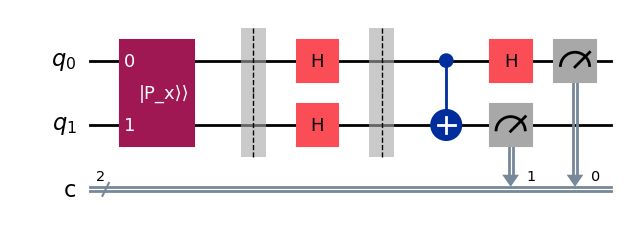

Bell state + Weyl operator


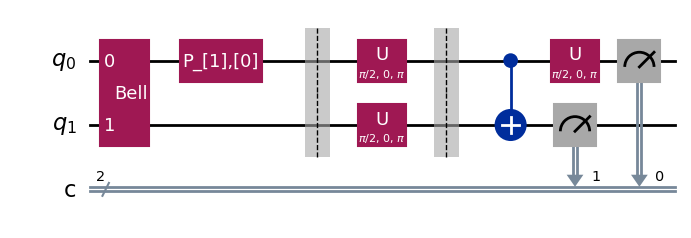

Base gates


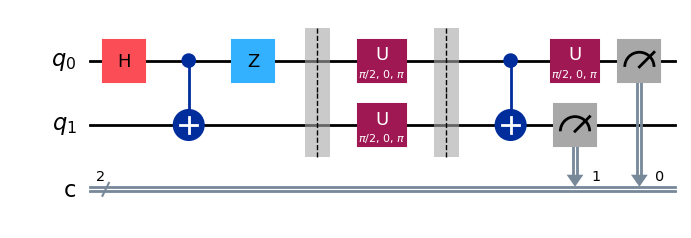

In [7]:
# == Drawing out tester circuits ==
import matplotlib.pyplot as plt
from IPython.display import display

tester_circuit_to_view = get_clifford_tester_circuit(H, 1, [1, 0])

print("Entire Weyl-Choi state")
display(tester_circuit_to_view.draw("mpl"))
plt.close()

print("Bell state + Weyl operator")
display(tester_circuit_to_view.decompose(reps=1).draw("mpl"))
plt.close()

print("Base gates")
display(tester_circuit_to_view.decompose(reps=2).draw("mpl"))
plt.close()